**Стартап по продаже продуктов питания**


анализ поведения пользователей мобильного приложения

# Содержание
[ТЗ](#TZ)

[служебные блоки](#code_block)

[1. обзор данных](#data_review)

[2. подготовка данных](#data_prepare)

[3. изучение данных](#data_discovery)

[4. воронка событий](#vorona)

[5. результаты эксперимента](#A_A_B_test)

>[5.1 расчёт результатов А/А эксперимента](#A_A_test)

>[5.2 расчёт результатов А/В эксперимента](#A_B_test)

[ вывод](#conclusion)

## ТЗ <a name="TZ"></a>

Задача: определить поведение пользователей мобильного приложения по продаже еды используя воронку продаж.

Определить:
* как пользователи доходят до покупки
* сколько пользователей доходит до покупки
* шаги, на которых "застревают" пользователи

Проанализировать проведённый А/А/В тест по изменению шрифтов в приложении



Описание данных

Каждая запись в логе — это действие пользователя, или событие.

номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## служебные блоки <a name="code_block"></a>

---
---

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats as st
import numpy as np

---
---


In [ ]:
def grafic_bar_1 (size_x, size_y, title, x_data, y_data, x_lable, y_lable ):
  fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(size_x,size_y))

  ax.set_title(title)
  ax.bar(x= x_data , height= y_data)
  ax.set_xlabel(x_lable)
  ax.set_ylabel(y_lable)
  plt.xticks(rotation=-45, ha='left')


  for bar in ax.patches:
      ax.annotate(bar.get_height(), 
                     (bar.get_x() + bar.get_width() / 2, 
                      bar.get_height()), ha='center', va='center',
                     size=15, xytext=(0, 8),
                     textcoords='offset points')
    
  plt.show()

In [ ]:
def ttest_func (df, znach1, znach2, group1, group2, alpha   ):
    gr_A = df[ ( (df['EventName'] == znach1) |  (df['EventName'] == znach2)  ) & (df['ExpId'] == group1) ]['rang_event_name']
    gr_B = df[ ( (df['EventName'] == znach1) |  (df['EventName'] == znach2)  ) & (df['ExpId'] == group2) ]['rang_event_name']
    #print(gr_A)
    results = st.ttest_ind(gr_A, gr_B, equal_var = False)
    
    if results.pvalue < alpha:
        return results.pvalue , False
    else:
        return results.pvalue , True


In [ ]:
def tabl_group_data (df, name1 , name2 , group):

  for i in range(4):
    df.loc[ i , name1] = df_log_end_clear[ ( df_log_end_clear['EventName'] == results_test['EventName'][i] ) & (df_log_end_clear['ExpId'] == group ) ]['DeviceIDHash'].nunique()

  df[ name2 ] = round( df[name1] / df[ name1 ].shift(+1) , 3)

---
---

## обзор данных <a name="data_review"></a>

In [ ]:
try:
  df_log = pd.read_csv('/datasets/logs_exp.csv',sep = '\t')
except:
  df_log = pd.read_csv('https://...logs_exp.csv',sep = '\t')

In [ ]:
df_log.sample(3)


,EventName,DeviceIDHash,EventTimestamp,ExpId
140338,CartScreenAppear,6991340031069409368,1564955287,246
238663,CartScreenAppear,4286084469604846869,1565198343,247
73728,PaymentScreenSuccessful,1989685320445148348,1564780061,247


In [ ]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [ ]:
print('уникальные значения номеров экспериметнов: ', df_log.ExpId.unique() )

уникальные значения номеров экспериметнов:  [246 248 247]


In [ ]:
print('кол-во дубликатов:', df_log.duplicated().sum() )

кол-во дубликатов: 413


учитывая тот факт, что время задано в секундах от стартового момента, то отметём версию, что пользователь успел дважды вызвать форму за один момент отсчитываемого времени (ну или не будем смотреть на супербыстрых пользователей постоянно обновляющих страницу (* как отличить  квакера от других- квакер после загрузки сразу жмёт F5). Поэтому будем считать, что у нас есть дубликаты

данные загружены. Явных пропусков нет. Есть необходимость преобразования типа даты, борьбы с дублкатами

## подготовка данных <a name="data_prepare"></a>

удалим дубликаты:

In [ ]:
df_log.drop_duplicates(inplace=True)

In [ ]:
#df_log.sample()

проверим на правильность распределения пользователей по группам (пользователь должен принадлежать только к одной группе, иначе- ошибка распределения и данные с такого пользователя могут исказить А-А-В тест):

In [ ]:
df_prob = df_log.groupby('DeviceIDHash')['ExpId'].nunique().to_frame()
if (df_prob['ExpId'].max() >1 ):
  print('есть ошибки в распределении пользователей')
else:
  print('распределние проведено верно')

распределние проведено верно


создадим столбцы с датами и временем и отдельный столбец с датой:


In [ ]:
df_log['date_time'] = pd.to_datetime(df_log['EventTimestamp'], unit='s')
df_log['date'] = df_log['date_time'].astype('datetime64[D]')
df_log.sample(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId,date_time,date
147504,OffersScreenAppear,7543879591140518446,1564992167,246,2019-08-05 08:02:47,2019-08-05
137831,MainScreenAppear,8969408093899945802,1564946005,248,2019-08-04 19:13:25,2019-08-04
226602,MainScreenAppear,5793836960337731722,1565179362,248,2019-08-07 12:02:42,2019-08-07
211202,PaymentScreenSuccessful,3447945165857834216,1565121862,247,2019-08-06 20:04:22,2019-08-06
163180,MainScreenAppear,4317170660410519835,1565016764,248,2019-08-05 14:52:44,2019-08-05


In [ ]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   EventName       243713 non-null  object        
 1   DeviceIDHash    243713 non-null  int64         
 2   EventTimestamp  243713 non-null  int64         
 3   ExpId           243713 non-null  int64         
 4   date_time       243713 non-null  datetime64[ns]
 5   date            243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


данные подготовили. можем начинать изучать

## изучение данных <a name="data_discovery"></a>

In [ ]:
print('кол-во событий в логе:' , len(df_log))
print('\nкол-во уникальных пользователей в логе:', df_log['DeviceIDHash'].nunique())
print('\nсреднее кол-во событий на одного пользователя:' , round( len(df_log) / df_log['DeviceIDHash'].nunique() , 2))
print('\nвременной период данных:', df_log['date_time'].min()  , ' - ' , df_log['date_time'].max())


кол-во событий в логе: 243713

кол-во уникальных пользователей в логе: 7551

среднее кол-во событий на одного пользователя: 32.28

временной период данных: 2019-07-25 04:43:36  -  2019-08-07 21:15:17


посмотрим на распределение

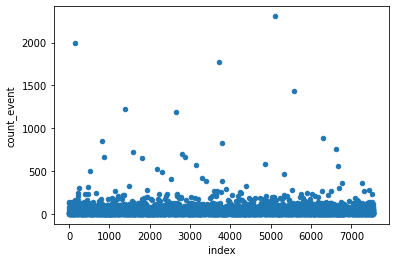

In [ ]:
df_log.groupby('DeviceIDHash')['EventTimestamp'].count().to_frame().reset_index().reset_index().rename(columns = {'EventTimestamp' : 'count_event'}).plot.scatter(x='index', y = 'count_event' )

впринципе, для оценки меры среднего значения лучше использовать медиану

In [ ]:
print('\nсреднее (медианное) кол-во событий на одного пользователя:' , 
      df_log.groupby('DeviceIDHash')['EventTimestamp'].count().to_frame().EventTimestamp.median()
     )


среднее (медианное) кол-во событий на одного пользователя: 20.0


построим гистограму распределения кол-ва логов по датам:

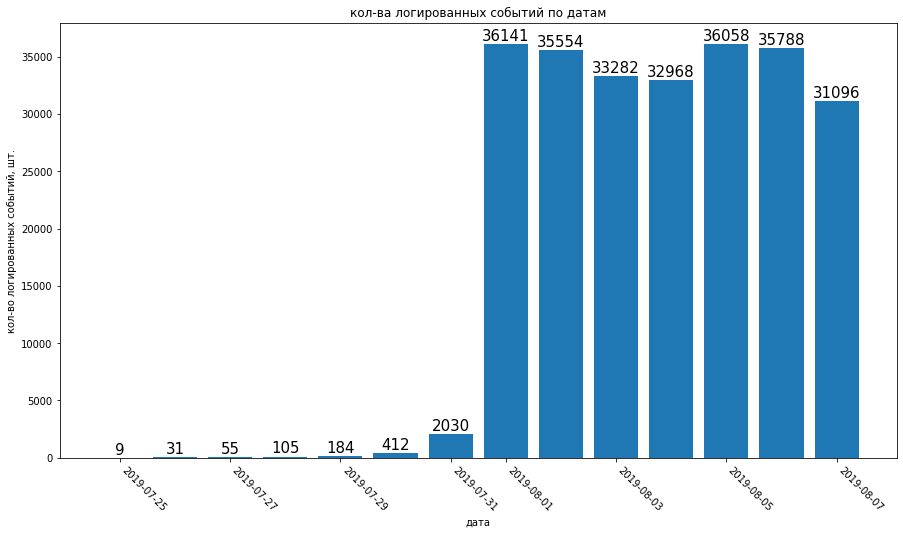

In [ ]:
grafic_bar_1 (
    15, 8
    , 'кол-ва логированных событий по датам'
    , df_log.groupby('date')['date_time'].count().reset_index().date
    , df_log.groupby('date')['date_time'].count().reset_index().date_time
    , 'дата'
    , 'кол-во логированных событий, шт.'
     )

можем увидеть на гистограмме перекос данных с 2019-08-01. Вероятно данные с более ранних дат ушли в поздние даты. Отбросим "пустые" с потерей небольшого кол-ва данных. дату обрезки данных сделаем с 2019-08-01 как первый полный день:


In [ ]:
df_log_end = df_log[df_log['date'] >= '2019-08-01']
#df_log_end

In [ ]:
print('реальный временной период данных:', df_log_end['date_time'].min()  , ' - ' , df_log_end['date_time'].max())
print('\nкол-во "потерянных" событий:', len(df_log) - len(df_log_end)  , 'шт. (', round( 100*(len(df_log) - len(df_log_end))/len(df_log) , 2) ,'% )')
print('\nкол-во пользователей в каждой экспериментальной  группе: \n', df_log_end.groupby('ExpId')['DeviceIDHash'].nunique().to_frame().rename(columns = {'DeviceIDHash': 'user_count'}))


реальный временной период данных: 2019-08-01 00:07:28  -  2019-08-07 21:15:17

кол-во "потерянных" событий: 2826 шт. ( 1.16 % )

кол-во пользователей в каждой экспериментальной  группе: 
        user_count
ExpId            
246          2484
247          2513
248          2537


данные изучены и проверены и мы готовы к получению полезного результата. В итоговых данных пользователи распределены по группам примерно равномерно

## воронка событий <a name="vorona"></a>

подготовим рабочую таблицу:


In [ ]:
df_voronka = df_log_end.groupby('EventName').agg({'date' : 'count', 'DeviceIDHash' : 'nunique'}).rename(columns = {'date' : 'event_name_count', 'DeviceIDHash' : 'users_count'})
df_voronka['users_part'] = df_voronka['users_count'] / df_log_end['DeviceIDHash'].nunique()
df_voronka

,event_name_count,users_count,users_part
EventName,,,
CartScreenAppear,42303,3734,0.495620
MainScreenAppear,117328,7419,0.984736
OffersScreenAppear,46333,4593,0.609636
PaymentScreenSuccessful,33918,3539,0.469737
Tutorial,1005,840,0.111495


посмотрим на частоту появления разных событий:

In [ ]:
df_voronka[['event_name_count']].sort_values('event_name_count', ascending = False)

,event_name_count
EventName,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


посмотрим какое кол-во уникальных пользователей совершали каждое событие и их долю от общего числа пользователей:

In [ ]:
df_voronka[['users_count' , 'users_part']].sort_values('users_count', ascending = False)

,users_count,users_part
EventName,,
MainScreenAppear,7419,0.984736
OffersScreenAppear,4593,0.609636
CartScreenAppear,3734,0.495620
PaymentScreenSuccessful,3539,0.469737
Tutorial,840,0.111495


события продажи продукта проходят в следующем порядке: Главный экран -> эркран продажи -> экран оплаты -> экран подтверждения факта оплаты. Экран с инструкцией в данном случае излишен (не нужен при расчёте воронки продаж). Избавимся от лишнего действия:

In [ ]:
df_voronka = df_voronka.sort_values('users_count', ascending = False).iloc[0:4]
df_voronka

,event_name_count,users_count,users_part
EventName,,,
MainScreenAppear,117328,7419,0.984736
OffersScreenAppear,46333,4593,0.609636
CartScreenAppear,42303,3734,0.495620
PaymentScreenSuccessful,33918,3539,0.469737


так же, учтём что не все пользователи заходили на главный экран (возможно из поисковых систем сразу попадали на экран продажи). Нам в данном случае не интересен путь таких пользователй (наша задача- исследовать приложение, которое пускается с главного экрана). Поэтому удалим таких пользователей и продолжим без них:

In [ ]:
df_log_end_clear = df_log_end[ df_log_end['DeviceIDHash'].isin(df_log_end[ df_log_end['EventName'] == 'MainScreenAppear']['DeviceIDHash'].unique()) ]
df_voronka_clear = df_log_end_clear.groupby('EventName').agg({'date' : 'count', 'DeviceIDHash' : 'nunique'}).rename(columns = {'date' : 'event_name_count', 'DeviceIDHash' : 'users_count'})
df_voronka_clear['users_part'] = df_voronka_clear['users_count'] / df_log_end_clear['DeviceIDHash'].nunique()
df_voronka_clear = df_voronka_clear.sort_values('users_count', ascending = False).iloc[0:4]
df_voronka_clear_rab = df_voronka_clear.copy()
df_voronka_clear

,event_name_count,users_count,users_part
EventName,,,
MainScreenAppear,117328,7419,1.000000
OffersScreenAppear,45385,4482,0.604125
CartScreenAppear,41394,3635,0.489958
PaymentScreenSuccessful,33171,3441,0.463809


посчитаем долю пользователей перешедших на следующий этап:

In [ ]:
df_voronka_clear['part_transit'] = round( df_voronka_clear['users_count'] / df_voronka_clear['users_count'].shift(+1) , 2)
df_voronka_clear.fillna(1.00, inplace = True)
display(df_voronka_clear)
print('\n доля пользователей прошедших весь цикл продажи:', round(df_voronka_clear['users_count'].min() / df_voronka_clear['users_count'].max()  ,2) )


,event_name_count,users_count,users_part,part_transit
EventName,,,,
MainScreenAppear,117328,7419,1.000000,1.00
OffersScreenAppear,45385,4482,0.604125,0.60
CartScreenAppear,41394,3635,0.489958,0.81
PaymentScreenSuccessful,33171,3441,0.463809,0.95



 доля пользователей прошедших весь цикл продажи: 0.46



как можем увидеть из таблицы- больше всего пользователей "теряется" при переходе к окну продажи (OffersScreenAppear). Если пользователдь всё-таки дошёл до покупки- небольша часть пользователей "отваливается" в процессе. Есть какая-то проблема по завершению оплаты (завершают только 95% пользователей). Возможно оставшиеся 5% пользователей используют системы оплаты, не поддерживаемые приложением. 

46% пользователей проходит весь путь от посещения сайта до завершения оплаты


## результаты эксперимента <a name="A_A_B_test"></a>

In [ ]:
print('\nкол-во пользователей в каждой экспериментальной  группе: \n', df_log_end_clear.groupby('ExpId')['DeviceIDHash'].nunique().to_frame().rename(columns = {'DeviceIDHash': 'user_count'}))


кол-во пользователей в каждой экспериментальной  группе: 
        user_count
ExpId            
246          2450
247          2476
248          2493


группы по кол-ву примерно равны. 

подготовим данные для ТТестов: заменим значение событий на числа для расчёта средней конверсии для каждого этапа:

In [ ]:
for i in range(len(df_log_end_clear['EventName'].unique())):
  df_log_end_clear.loc[ df_log_end_clear['EventName'] == df_log_end_clear['EventName'].unique()[i] , 'rang_event_name'] = i

df_log_end_clear.sample(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,EventName,DeviceIDHash,EventTimestamp,ExpId,date_time,date,rang_event_name
112285,MainScreenAppear,1207877788215001499,1564902279,246,2019-08-04 07:04:39,2019-08-04,1.0
59070,PaymentScreenSuccessful,4887737919252726639,1564753412,247,2019-08-02 13:43:32,2019-08-02,4.0
10925,MainScreenAppear,4595859422077715633,1564649324,248,2019-08-01 08:48:44,2019-08-01,1.0


данные подготовлены можно начинать счтать

считать будем равенство средних конверсий для каждого перехода (например, MainScreenAppear в OffersScreenAppear) 

### расчёт результатов А/А эксперимента <a name="A_A_test"></a>

In [ ]:
#df_voronka_clear

примем уровень доверия- 0,05. За нулевую гипотезу примем, что статистически значимых различий между группами нет. Проверим каждую конверсию (по каждому этапу и занесём данные в таблицу). Применим параметрический метод (в нашем случае метод Стьюдента) к свойству "конверсия"

"нулевая" гипотеза Н0: статистически значимых различий между группами нет

альтернативная гипотеза Н1: статистически значимые различия между группами наблюдаются (есть)

In [ ]:
results_test = df_voronka_clear.reset_index().EventName.to_frame()
#results_test

In [ ]:
for i in range(1, 4):
    ff =ttest_func (df_log_end_clear, results_test['EventName'][i-1], results_test['EventName'][i], 246 , 247, 0.05   )
    results_test.loc[ i , 'AA_p_value'] = round(ff[0] , 3)
    results_test.loc[ i , 'AA_viborki_ravni'] = ff[1]
  
  
results_test

,EventName,AA_p_value,AA_viborki_ravni
0,MainScreenAppear,NaN,NaN
1,OffersScreenAppear,0.363,True
2,CartScreenAppear,0.000,False
3,PaymentScreenSuccessful,0.908,True


как можем увидеть из таблицы- конверсия при переходе из OffersScreenAppear в CartScreenAppear различается. Остальные 2 конверсии статистически не различимы

заполним данные по каждой исследуемой группе в нашей таблице:

In [ ]:
tabl_group_data(
    results_test
    , '246_user_count'
    , '246_part_transit'
    , 246
)

tabl_group_data(
    results_test
    , '247_user_count'
    , '247_part_transit'
    , 247
)

results_test

,EventName,AA_p_value,AA_viborki_ravni,246_user_count,246_part_transit,247_user_count,247_part_transit
0,MainScreenAppear,NaN,NaN,2450.0,NaN,2476.0,NaN
1,OffersScreenAppear,0.363,True,1509.0,0.616,1484.0,0.599
2,CartScreenAppear,0.000,False,1236.0,0.819,1207.0,0.813
3,PaymentScreenSuccessful,0.908,True,1170.0,0.947,1128.0,0.935


можем увидеть различие между группам по конверсии OffersScreenAppear в CartScreenAppear (столбец "AA_viborki_ravni" == False - говорть что есть статистически значимая разница). Можем сказать что группы А1 и А2 выбраны неверно. С другой тороны, конверсия в окно PaymentScreenSuccessful из CartScreenAppear статистически не различимы, так же как и попадание на страницу покупки.

### расчёт результатов А/В эксперимента <a name="A_B_test"></a>

добавим результаты обсчёта тестов в туже таблицу

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#df_log_end_clear.head()

создадим таблицу с исходными данными:

In [ ]:
df_z_test_group_by = df_log_end_clear[ df_log_end_clear['EventName'] != 'Tutorial' ].groupby(['EventName','ExpId'])['DeviceIDHash'].nunique().to_frame().rename(columns={'DeviceIDHash':'count_nunique'}).sort_values('count_nunique', ascending = False)
df_z_test_group_by

count_nunique
EventName               ExpId               
MainScreenAppear        248             2493
                        247             2476
                        246             2450
OffersScreenAppear      246             1509
                        248             1489
                        247             1484
CartScreenAppear        246             1236
                        247             1207
                        248             1192
PaymentScreenSuccessful 246             1170
                        248             1143
                        247             1128

In [ ]:
#df_z_test_group_by.index


In [ ]:
#df_voronka_clear_rab

напишем функцию проверки и создания таблиц:

In [ ]:
# дополним таблицу суммарным (А1 и А2) измерением
result = df_voronka_clear_rab.copy()
for i in range(0,4):
        
        df_z_test_group_by.loc[ (result.index[i], 555) , 'count_nunique'] =(
            df_z_test_group_by.loc[ (result.index[i], 246) , 'count_nunique'] +
            df_z_test_group_by.loc[ (result.index[i], 247) , 'count_nunique']       
        )       

#df_z_test_group_by

In [ ]:


def z_test_table(group, kriteriy , alpha):
    result = df_voronka_clear_rab.copy()
    for i in range(1,4):
        count = df_z_test_group_by.loc[ (result.index[i], group) , 'count_nunique']
        nobs = df_z_test_group_by.loc[ ( 'MainScreenAppear', group) , 'count_nunique']
        value = df_z_test_group_by.loc[ (result.index[i], kriteriy ) , 'count_nunique'] / df_z_test_group_by.loc[ ( 'MainScreenAppear', kriteriy), 'count_nunique']
        stat, pval = proportions_ztest(count, nobs, value)
        #print(pval)
                
        result.loc[result.index[i] ,'p_value']=pval
        
        if (pval > alpha):
            result.loc[result.index[i] ,'viborki_ravni']= True
        else:
            result.loc[result.index[i] ,'viborki_ravni']= False
        
        
    return result[['p_value','viborki_ravni']]
    
    

**результаты А1-A2 тестирования**

In [ ]:
z_test_table(246, 247, 0.05)

,p_value,viborki_ravni
EventName,,
MainScreenAppear,NaN,NaN
OffersScreenAppear,0.091846,True
CartScreenAppear,0.092187,True
PaymentScreenSuccessful,0.029417,False


**результаты А1-В тестирования**

In [ ]:
z_test_table(246, 248, 0.05)

,p_value,viborki_ravni
EventName,,
MainScreenAppear,NaN,NaN
OffersScreenAppear,0.057754,True
CartScreenAppear,0.009088,False
PaymentScreenSuccessful,0.058829,True


**результаты А2-В тестирования**

In [ ]:
z_test_table(247, 248, 0.05)

,p_value,viborki_ravni
EventName,,
MainScreenAppear,NaN,NaN
OffersScreenAppear,0.832609,True
CartScreenAppear,0.352423,True
PaymentScreenSuccessful,0.771224,True


**результаты А1А2-В тестирования**

In [ ]:
z_test_table(555, 248, 0.05)

,p_value,viborki_ravni
EventName,,
MainScreenAppear,NaN,NaN
OffersScreenAppear,0.137974,True
CartScreenAppear,0.012460,False
PaymentScreenSuccessful,0.259159,True


**кол-во пользователей по выборкам (555- суммарная выборка ждя групп 246 и 247)**

In [ ]:
df_z_test_group_by

count_nunique
EventName               ExpId               
MainScreenAppear        248           2493.0
                        247           2476.0
                        246           2450.0
OffersScreenAppear      246           1509.0
                        248           1489.0
                        247           1484.0
CartScreenAppear        246           1236.0
                        247           1207.0
                        248           1192.0
PaymentScreenSuccessful 246           1170.0
                        248           1143.0
                        247           1128.0
MainScreenAppear        555           4926.0
OffersScreenAppear      555           2993.0
CartScreenAppear        555           2443.0
PaymentScreenSuccessful 555           2298.0

Было проведено 4*3 = 12 проверки статистических гипотез при уровне значимаости 0,05. При таком уровне значимаости каждый 20 анализ может получиться ложнымю Но при условии, что полученные уровни значимаости (p value)  находятся далеко от 0,05- результаты можно считать надёжными. Так же, мы считаем наши выборки независимыми друг от друга, т.е. нельзя говорить, что какой-то из результатов стат теста будет ложным при большом кол-ве стат тестов на разных (независимых) выборках. параметр Альфа- это пороговое значение, которое даёт с определённым уровнем доверия возможность строго (математически) оценить различия в выборках. При необходимости включения в результаты измерений параметров случайных выбросов мы можем проверить наши выборки на грубвые выбросы (ГОСТ 8.207-76 и ГОСТ 11.002-73)(правда, это работает только на измерениях- т.е. на не бимодальных величинах) или включить расчёт доверительного интервала (СКО при необходимости) в выводные результаты)

Строго говоря, уровень стат значимости выбирается не из кол-ва тестов а из необходимости консервативного похода к измерениям (т.е. чем выше значимость измерений, тем уровень доверия должен быть выше (67%, 95%, 99%, 99,7%...). С точки зрения значимости данного измерения: в уровене доверия в 99% нет необходимости (это не медицинские исследования), уровень доверия 67% тоже не сильно подходит (этот соц опросы- у нас вопрос денег), поэтому выбираем стандартный - 95%

## вывод <a name="conclusion"></a>

А-А-В эксперимент не удался. Произошёл какой-то сбой в распреелении пользователей по группам. Для 2-ух контрольных групп (А1 и А2) наййдены статистически значимые различия, которых быть не должно. 

была получена предварительная картинка конверсии между окон (ошибка в эксперименте могла несколько повлиять на результат, но глобально она его не изменила):

In [ ]:
df_voronka_clear[['event_name_count','users_count','part_transit']]

,event_name_count,users_count,part_transit
EventName,,,
MainScreenAppear,117328,7419,1.00
OffersScreenAppear,45385,4482,0.60
CartScreenAppear,41394,3635,0.81
PaymentScreenSuccessful,33171,3441,0.95


Можем наблюдать хороший уровень конверсии из просмотра главной страницы в страницу продажи товара (60%). Далее 81% пользователей переходит непосредственно к оплате. НО оплатить получается только у 95% пользователей, что может быть объяснено оплатой нестандартным способом, который не может обеспечить системаприёма платеей приложения. Данная проблема служит потерией 5% платёжеспособны клиентов. Необходимо как-то поправить данный момент.